# Introduction 
 
La classification des tumeurs par scanner cérébral est un projet d'apprentissage automatique basé sur des données fournies par des [universitaires](https://github.com/aaliyahfiala42/DATA515-Brain-Scan-Classification). L'objectif de ce projet est de classifier les images de scanners cérébraux 2D en tant que *tumeurs* ou *non tumeurs*.

Trois modèles ont été développés pour la classification des tumeurs cérébrales : le modèle **VGG16**, le modèle **Inception V3** et un modèle basé sur l'algorithme de recherche aléatoire pour optimiser les hyperparamètres.

Les modèles **VGG16** et **Inception V3** utilisent des réseaux de neurones convolutionnels pré-entraînés, mais sans les couches fully-connected. Les images d'entrée sont converties en noir et blanc à l'aide d'une couche de conversion, puis sont passées à travers les couches convolutives du modèle respectif (VGG16 ou Inception V3). Ensuite, une couche de **Global Average Pooling** est utilisée pour réduire les dimensions spatiales des caractéristiques extraites. Des couches fully-connected avec des activations **ReLU** sont ajoutées, suivies de couches de **Dropout** pour régulariser le modèle. Enfin, une couche de sortie avec une activation **sigmoïde** est utilisée pour prédire si l'image contient une tumeur ou non.

Le troisième modèle est construit en utilisant l'algorithme de recherche aléatoire pour optimiser les hyperparamètres. Il utilise une couche convolutive avec un nombre de filtres et une taille de noyau choisis dynamiquement à partir des hyperparamètres. Une couche de **MaxPooling** est utilisée pour réduire les dimensions spatiales, suivie d'une opération de mise à plat (*Flatten*). Ensuite, des couches fully-connected avec des activations **ReLU** sont ajoutées, avec des unités et un taux de dropout sélectionnés par l'algorithme de recherche aléatoire. Enfin, une couche de sortie avec une activation **sigmoïde** est utilisée pour prédire si l'image contient une tumeur ou non.

Il est important de noter que, en raison de la quantité limitée de données disponibles (253 images), ces modèles ne sont pas généralisables à grande échelle. Ils ont été développés dans un but purement expérimental, afin d'explorer les capacités de classification des tumeurs cérébrales à partir d'images de scanner.

In [ ]:
import os
import numpy as np
import cv2
from PIL import Image

import seaborn as sns
from matplotlib import pyplot as plt

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Input,GlobalAveragePooling2D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionV3
import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.metrics import roc_curve, auc, recall_score, precision_score

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# Configuration pour éviter les erreurs de mémoire insuffisante sur les GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU') # Vérifie les périphériques GPU disponibles

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
path = '/kaggle/input/brain-mri-images-for-brain-tumor-detection'
directory = os.path.join(path, 'brain_tumor_dataset')

In [5]:
class_names= ['no', 'yes']
batch_size = 32
image_size = (224, 224)

In [6]:
# Chargement des images à partir du répertoire
brain_tumor = tf.keras.utils.image_dataset_from_directory(
    directory=directory,
    label_mode='binary',
    class_names=class_names,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=image_size
)

Found 253 files belonging to 2 classes.


In [7]:
# Normalisation des valeurs des pixels
brain_tumor = brain_tumor.map(lambda x, y: (x / 255.0, y)) # normalisation
batch = brain_tumor.as_numpy_iterator().next()
batch[0].min(), batch[0].max()

(0.0, 1.0)

Nous normalisons les valeurs des pixels dans le but de mettre les données à une échelle appropriée entre *0 et 1* pour l'apprentissage automatique. Les valeurs des pixels représentent l'intensité lumineuse des différentes parties de l'image, et elles peuvent varier dans une large plage, par exemple, de *0 à 255* pour les images en niveaux de gris.

In [8]:
labeled_data = brain_tumor.map(lambda x, y: (x, y))
images_labels = list(labeled_data.unbatch())

In [9]:
# Division de l'ensemble de données en ensembles d'entraînement, de validation et de test
train_data, test_data, train_labels, test_labels = train_test_split(
    np.array([image for image, label in images_labels]),
    np.array([label for image, label in images_labels]),
    test_size=0.2,
    random_state=42
)

train_data, val_data, train_labels, val_labels = train_test_split(
    train_data, 
    train_labels, 
    test_size=0.2, 
    random_state=42
)

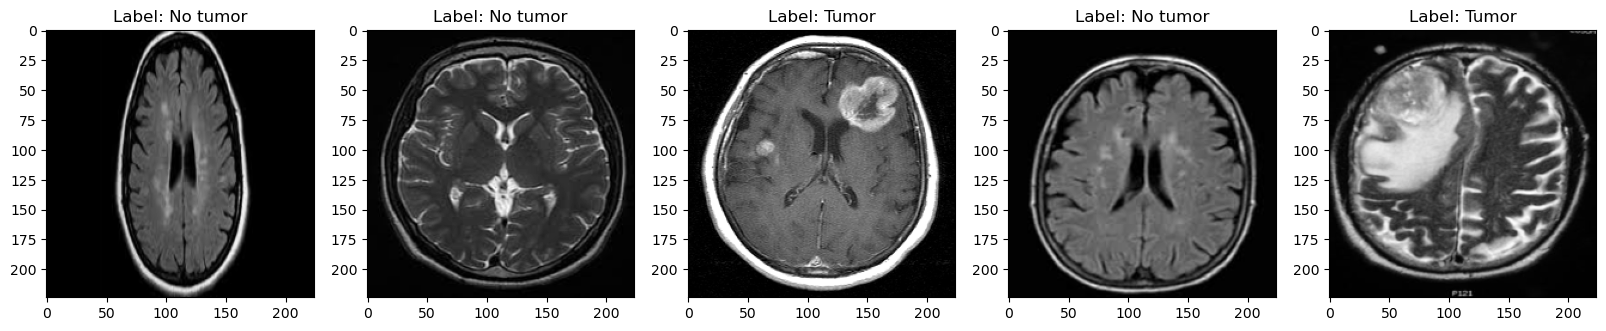

In [10]:
# Visualisation de 5 images
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,20))
for i in range(5):
    axes_flat = axes.flatten()
    axes_flat[i].imshow(train_data[i], cmap=plt.cm.gray)
    axes_flat[i].set_title('Label: %s' % ('Tumor' if train_labels[i] else 'No tumor'))

# **Image Data Generator**

In [11]:
# Définition des transformations à appliquer
data_generator = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
)

# Ajustement du générateur aux données
data_generator.fit(train_data)

# Génère des données supplémentaires
augmented_data = data_generator.flow(
    train_data, train_labels.reshape(-1, 1),
    batch_size=batch_size,
    shuffle=True,
)

Le code ci-dessus définit un générateur de données d'images augmentées, ce qui signifie qu'il crée de nouvelles versions des images d'entraînement en appliquant diverses transformations. Ces transformations incluent la rotation, le zoom, le décalage horizontal et vertical, ainsi que la possibilité de retourner les images horizontalement et verticalement.

# **Convolutional Neural Network**

In [12]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'accuracy' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'accuracy' in s and 'val' in s]

    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 

    plt.figure(figsize=(12, 8))
    fig, axs = plt.subplots(1, 2, figsize=(20,5))
    
    # Loss
    for l in loss_list:
        axs[0].plot(history.history[l], label='Train loss (' + str(str(format(history.history[l][-1], '.5f'))+')'))
    for l in val_loss_list:
        axs[0].plot(history.history[l], label='Validation loss (' + str(str(format(history.history[l][-1], '.5f'))+')'))
    
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc='upper right')
    
    # Accuracy
    for l in acc_list:
        axs[1].plot(history.history[l], label='Train accuracy (' + str(format(history.history[l][-1], '.5f'))+')')
    for l in val_acc_list:
        axs[1].plot(history.history[l], label='Validation accuracy (' + str(format(history.history[l][-1], '.5f'))+')')
    
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(loc='lower right')
    
    plt.show()

In [13]:
def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch > 0:
        return lr / 2
    else:
        return lr

Dans cette fonction, on vérifie si l'époque actuelle (*epoch*) est un multiple de 10 et supérieure à zéro. Si cette condition est vraie, le taux d'apprentissage est réduit de moitié en retournant *lr / 2*. Cela permet de diminuer progressivement le taux d'apprentissage à des moments spécifiques de l'entraînement, ce qui peut être bénéfique pour améliorer la convergence du modèle et éviter de rester coincé dans des minimas locaux.

## **VGG16**

In [14]:
# Chargement du modèle VGG16 sans les couches fully-connected
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3), classes=1)

# Couche de conversion pour les images en noir et blanc
inputs = Input(shape=(224, 224, 1))
rgb_inputs = Lambda(lambda x: tf.concat([x, x, x], axis=-1))(inputs)

# Gel des poids des couches pré-entraînées
for layer in vgg16.layers:
    layer.trainable = False

# Architecture de classification
x = vgg16(rgb_inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

# Le modèle final
tumor_classifier_vgg16 = Model(inputs=inputs, outputs=outputs)

# Compilation du modèle
tumor_classifier_vgg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


In [15]:
tumor_classifier_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                             

Epoch 1/1000
6/6 [==============================] - 12s 421ms/step - loss: 0.6826 - accuracy: 0.5776 - val_loss: 0.6264 - val_accuracy: 0.6829 - lr: 0.0010
Epoch 2/1000
6/6 [==============================] - 1s 163ms/step - loss: 0.7155 - accuracy: 0.6273 - val_loss: 0.6101 - val_accuracy: 0.6829 - lr: 0.0010
Epoch 3/1000
6/6 [==============================] - 1s 164ms/step - loss: 0.6315 - accuracy: 0.6646 - val_loss: 0.5951 - val_accuracy: 0.6829 - lr: 0.0010
Epoch 4/1000
6/6 [==============================] - 1s 156ms/step - loss: 0.7172 - accuracy: 0.5280 - val_loss: 0.6364 - val_accuracy: 0.8049 - lr: 0.0010
Epoch 5/1000
6/6 [==============================] - 1s 134ms/step - loss: 0.7166 - accuracy: 0.5528 - val_loss: 0.5901 - val_accuracy: 0.6829 - lr: 0.0010
Epoch 6/1000
6/6 [==============================] - 1s 142ms/step - loss: 0.6388 - accuracy: 0.6211 - val_loss: 0.5729 - val_accuracy: 0.6829 - lr: 0.0010
Epoch 7/1000
6/6 [==============================] - 1s 137ms/step - l

<Figure size 1200x800 with 0 Axes>

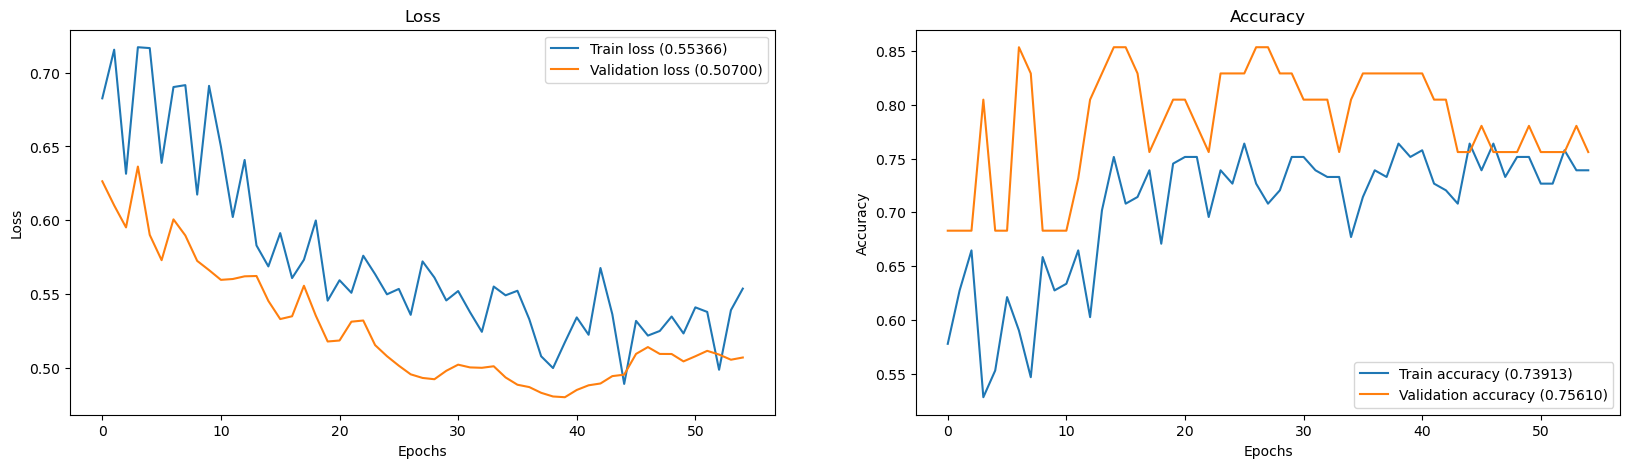

In [16]:
es = EarlyStopping(monitor='val_loss', patience=15)
lr_schedule = LearningRateScheduler(lr_scheduler)
history = tumor_classifier_vgg16.fit(augmented_data, epochs=1000, validation_data=(val_data, val_labels), callbacks=[es, lr_schedule])
plot_history(history)

# **Model Evaluation**

In [17]:
def evaluate_model(model, test_data, test_labels):
    # Évaluation du modèle sur les données de test
    model.evaluate(test_data, test_labels)
    
    # Prédiction des classes pour les données de test
    y_pred = model.predict(test_data)
    y_pred_classes = np.round(y_pred)

    # Calcul de la matrice de confusion
    cm = confusion_matrix(test_labels, y_pred_classes)

    # Rapport de classification
    clr = classification_report(test_labels, y_pred_classes)

    # Affichage de la matrice de confusion
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=False, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    print("Classification Report:\n----------------------\n", clr)

2/2 [==============================] - 0s 59ms/step


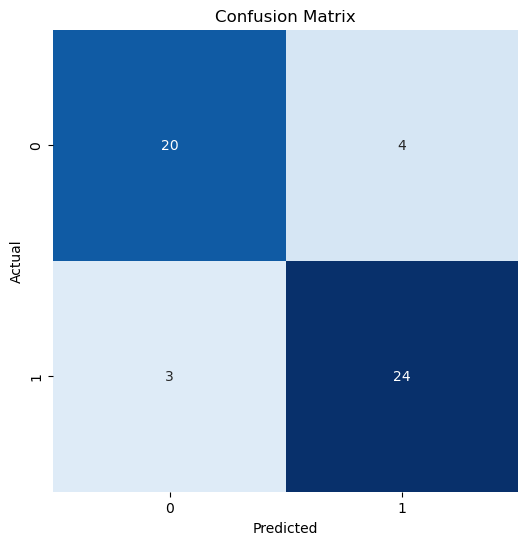

Classification Report:
----------------------
               precision    recall  f1-score   support

         0.0       0.87      0.83      0.85        24
         1.0       0.86      0.89      0.87        27

    accuracy                           0.86        51
   macro avg       0.86      0.86      0.86        51
weighted avg       0.86      0.86      0.86        51



In [18]:
evaluate_model(tumor_classifier_vgg16, test_data, test_labels)

In [19]:
def plot_roc_curve(model, test_data, test_labels):
    # Prédiction des classes pour les données de test
    y_pred = model.predict(test_data)
    # Calcul du taux de faux positifs (FPR), du taux de vrais positifs (TPR) et des seuils
    fpr, tpr, thresholds = roc_curve(test_labels, y_pred)

    # Calcul de l'aire sous la courbe ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Trace la courbe ROC
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

2/2 [==============================] - 0s 60ms/step


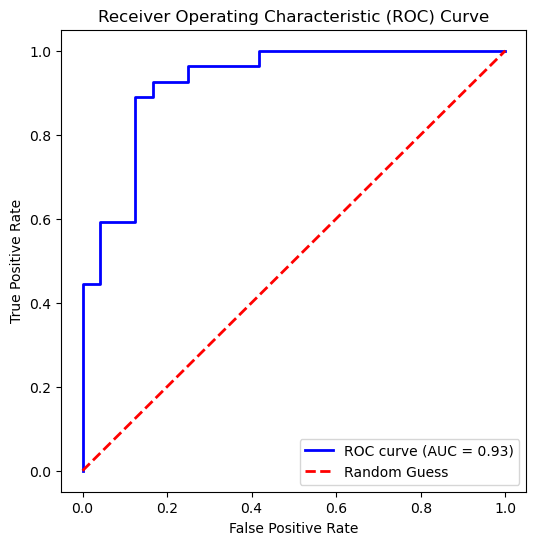

In [20]:
plot_roc_curve(tumor_classifier_vgg16, test_data, test_labels)

In [21]:
def scores(model, test_data, test_labels):
    # Prédiction des classes pour les données de test
    y_pred = model.predict(test_data)
    y_pred_classes = np.round(y_pred)

    # Calcul des scores avec arrondi à 2 décimales
    f1 = round(f1_score(test_labels, y_pred_classes), 2)
    recall = round(recall_score(test_labels, y_pred_classes), 2)
    precision = round(precision_score(test_labels, y_pred_classes), 2)

    # Affichage des scores
    print("F1 score:", f1)
    print("Recall score:", recall)
    print("Precision score:", precision)

In [22]:
scores(tumor_classifier_vgg16, test_data, test_labels)

2/2 [==============================] - 0s 60ms/step
F1 score: 0.87
Recall score: 0.89
Precision score: 0.86


## **Inception V3**

In [29]:
# Chargement du modèle InceptionV3 sans les couches fully-connected
inceptionV3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3), classes=1)

# Couche de conversion pour les images en noir et blanc
inputs = Input(shape=(224, 224, 1))
rgb_inputs = Lambda(lambda x: tf.concat([x, x, x], axis=-1))(inputs)

# Gel des poids des couches pré-entraînées
for layer in inceptionV3.layers:
    layer.trainable = False

# Architecture de classification
x = inceptionV3(rgb_inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

# Le modèle final
tumor_classifier_inceptionV3 = Model(inputs=inputs, outputs=outputs)

# Compilation du modèle
tumor_classifier_inceptionV3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

87910968/87910968 [==============================] - 1s 0us/step


In [30]:
tumor_classifier_inceptionV3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 lambda_2 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 256)               524544    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                           

Epoch 1/1000
6/6 [==============================] - 9s 536ms/step - loss: 0.9423 - accuracy: 0.5714 - val_loss: 0.5973 - val_accuracy: 0.6341 - lr: 0.0010
Epoch 2/1000
6/6 [==============================] - 1s 124ms/step - loss: 0.8880 - accuracy: 0.5901 - val_loss: 0.5532 - val_accuracy: 0.7561 - lr: 0.0010
Epoch 3/1000
6/6 [==============================] - 1s 141ms/step - loss: 0.8899 - accuracy: 0.5590 - val_loss: 0.5325 - val_accuracy: 0.8293 - lr: 0.0010
Epoch 4/1000
6/6 [==============================] - 1s 154ms/step - loss: 0.6264 - accuracy: 0.7205 - val_loss: 0.5035 - val_accuracy: 0.8293 - lr: 0.0010
Epoch 5/1000
6/6 [==============================] - 1s 150ms/step - loss: 0.6137 - accuracy: 0.7391 - val_loss: 0.5612 - val_accuracy: 0.6585 - lr: 0.0010
Epoch 6/1000
6/6 [==============================] - 1s 146ms/step - loss: 0.8035 - accuracy: 0.6522 - val_loss: 0.4600 - val_accuracy: 0.8537 - lr: 0.0010
Epoch 7/1000
6/6 [==============================] - 1s 200ms/step - lo

<Figure size 1200x800 with 0 Axes>

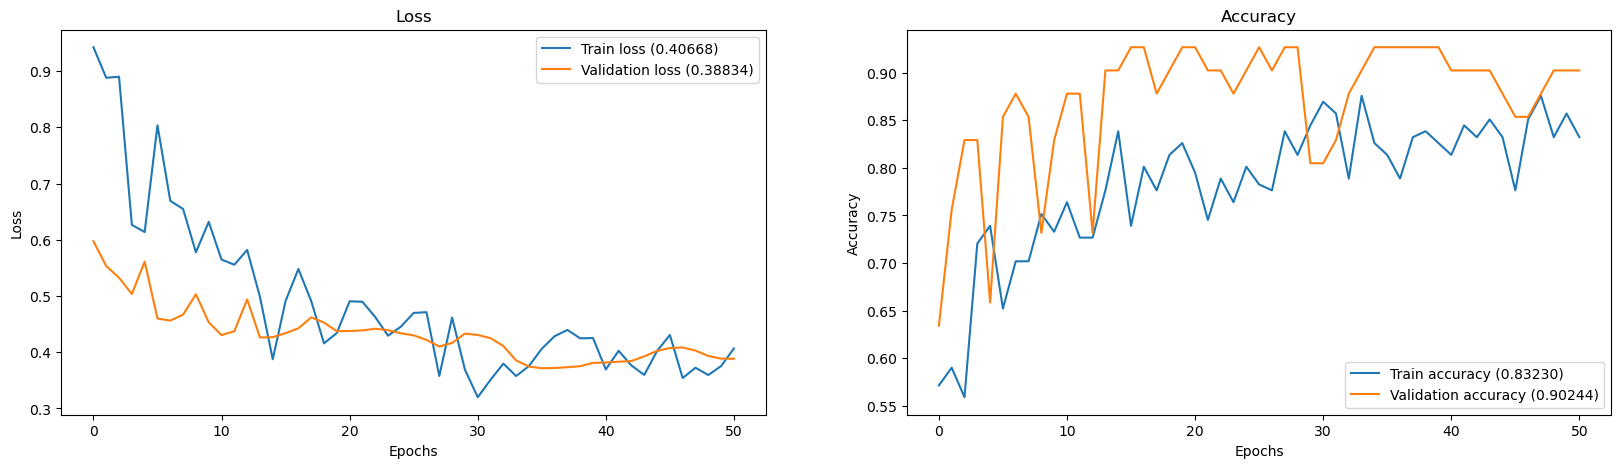

In [31]:
history = tumor_classifier_inceptionV3.fit(augmented_data, epochs=1000, validation_data=(val_data, val_labels), callbacks=[es, lr_schedule])
plot_history(history)

2/2 [==============================] - 1s 40ms/step


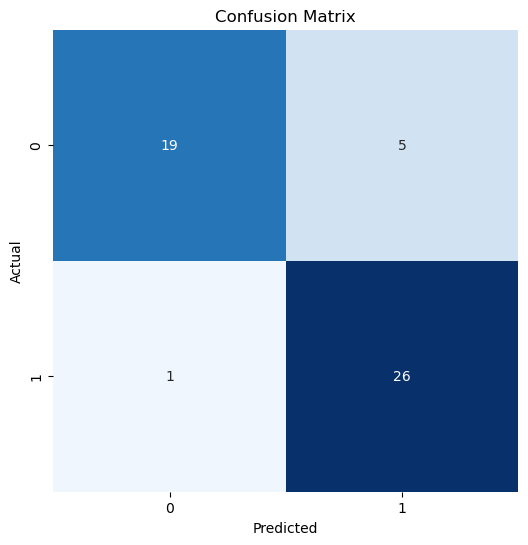

Classification Report:
----------------------
               precision    recall  f1-score   support

         0.0       0.95      0.79      0.86        24
         1.0       0.84      0.96      0.90        27

    accuracy                           0.88        51
   macro avg       0.89      0.88      0.88        51
weighted avg       0.89      0.88      0.88        51



In [32]:
evaluate_model(tumor_classifier_inceptionV3, test_data, test_labels)

2/2 [==============================] - 0s 41ms/step


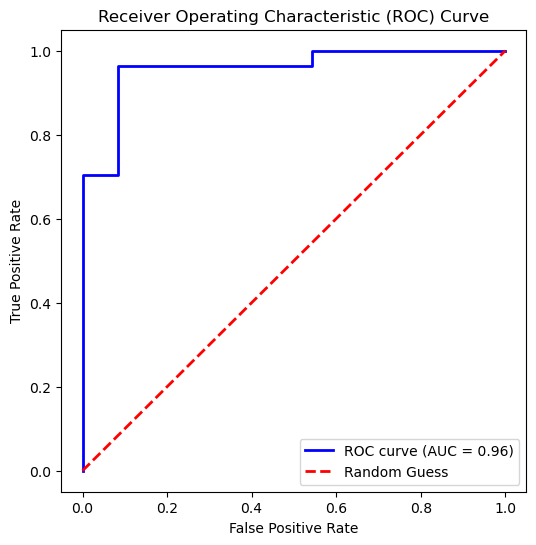

In [33]:
plot_roc_curve(tumor_classifier_inceptionV3, test_data, test_labels)

In [34]:
scores(tumor_classifier_inceptionV3, test_data, test_labels)

2/2 [==============================] - 0s 41ms/step
F1 score: 0.9
Recall score: 0.96
Precision score: 0.84


# **RandomSearch Tuner**

In [35]:
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import RandomSearch

In [36]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(filters=hp.Int('filters_1', min_value=16, max_value=128, step=16),
                            kernel_size=hp.Choice('kernel_1', values=[3, 5]),
                            activation='relu',
                            input_shape=(224, 224, 1)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(units=hp.Int('units', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.3, step=0.1)))
    model.add(layers.Dense(units=1, activation='sigmoid'))

    optimizer = keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [37]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='my_dir',
    project_name='brain_tumor')

# Recherche des hyperparamètres optimaux
tuner.search(augmented_data, epochs=20, validation_data=(val_data, val_labels), callbacks=[es, lr_schedule])
# Affichage des résultats
tuner.results_summary()

Trial 5 Complete [00h 00m 38s]
val_accuracy: 0.8048780560493469

Best val_accuracy So Far: 0.8292682766914368
Total elapsed time: 00h 04m 56s
Results summary
Results in my_dir/brain_tumor
Showing 10 best trials
Trial summary
Hyperparameters:
filters_1: 32
kernel_1: 3
units: 160
dropout: 0.1
learning_rate: 0.001
Score: 0.8292682766914368
Trial summary
Hyperparameters:
filters_1: 112
kernel_1: 5
units: 224
dropout: 0.1
learning_rate: 0.001
Score: 0.8292682766914368
Trial summary
Hyperparameters:
filters_1: 48
kernel_1: 3
units: 32
dropout: 0.1
learning_rate: 0.001
Score: 0.8048780560493469
Trial summary
Hyperparameters:
filters_1: 32
kernel_1: 5
units: 160
dropout: 0.0
learning_rate: 0.001
Score: 0.8048780560493469
Trial summary
Hyperparameters:
filters_1: 112
kernel_1: 3
units: 224
dropout: 0.0
learning_rate: 0.001
Score: 0.7804877758026123


# **Model Evaluation**

In [38]:
# Récupération du meilleur modèle
tuner_best_model = tuner.get_best_models(num_models=1)[0]

In [39]:
tuner_best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 394272)            0         
                                                                 
 dense (Dense)               (None, 160)               63083680  
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 161       
                                                        

2/2 [==============================] - 0s 5ms/step


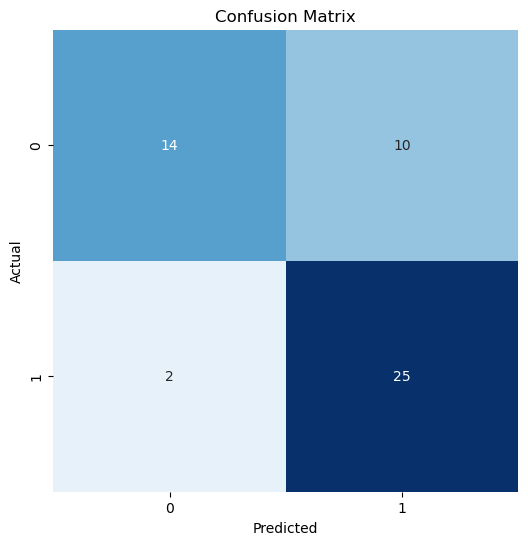

Classification Report:
----------------------
               precision    recall  f1-score   support

         0.0       0.88      0.58      0.70        24
         1.0       0.71      0.93      0.81        27

    accuracy                           0.76        51
   macro avg       0.79      0.75      0.75        51
weighted avg       0.79      0.76      0.76        51



In [40]:
evaluate_model(tuner_best_model, test_data, test_labels)

2/2 [==============================] - 0s 6ms/step


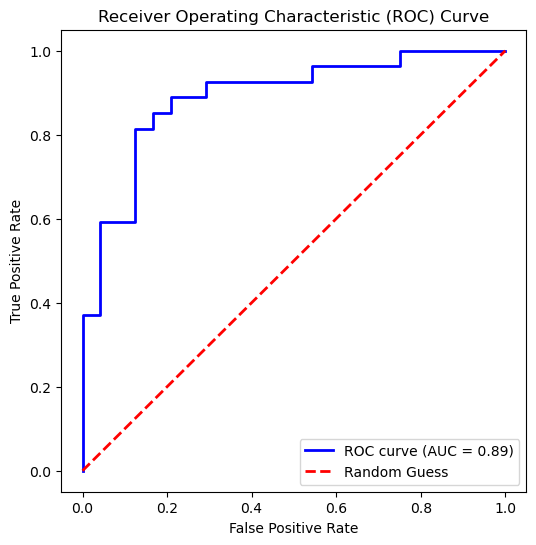

In [41]:
plot_roc_curve(tuner_best_model, test_data, test_labels)

In [42]:
scores(tuner_best_model, test_data, test_labels)

2/2 [==============================] - 0s 5ms/step
F1 score: 0.81
Recall score: 0.93
Precision score: 0.71


# Conclusion

| Modèle   | Précision | Rappel | Score F1 | AUC   |
|----------|-----------|--------|----------|-------|
| Modèle 1 | 0.86      | 0.89   | 0.87     | 0.93  |
| Modèle 2 | 0.84      | 0.96   | 0.9      | 0.96  |
| Modèle 3 | 0.71      | 0.93   | 0.81     | 0.89  |

En analysant les métriques, on constate que le Modèle 2 (*Inception V3*) présente la meilleure performance globale par rapport aux autres modèles. Il affiche une précision de 0,84, un rappel de 0,96 et un score F1 de 0,9. De plus, son AUC est de 0,96, ce qui suggère une excellente capacité de discrimination entre les classes.

Le Modèle 1 (*VGG16*) affiche également de bonnes performances avec une précision de 0,86, un rappel de 0,89 et un score F1 de 0,87. Son AUC est de 0,93, ce qui indique une bonne performance globale.

Le Modèle 3 a les performances les plus faibles parmi les trois modèles, avec une précision de 0,71, un rappel de 0,93 et un score F1 de 0,81. Son AUC est de 0,89, ce qui est relativement bon, mais inférieur aux autres modèles.

En conclusion, le Modèle 2 est le meilleur choix en termes de performances globales, avec des résultats supérieurs en termes de précision, de rappel, de score F1 et d'AUC. Cependant, il est important de prendre en compte d'autres facteurs tels que la taille de l'ensemble de données et les spécificités de la tâche avant de prendre une décision finale.